In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, precision_recall_curve, auc
from sklearn.preprocessing import MultiLabelBinarizer
import seaborn as sns
import matplotlib.pyplot as plt
import json
import lime
import lime.lime_tabular
from joblib import dump, load
from keras.callbacks import EarlyStopping

In [2]:
X_train = pd.read_csv('dati/X_train.csv')
X_test = pd.read_csv('dati/X_test.csv')
y_test = pd.read_csv('dati/y_test.csv')
print("X_train:", X_train.shape)
print("X_test:",X_test.shape)

X_train: (433924, 67)
X_test: (132703, 67)


In [137]:
# Definizione dell'input layer
input_dim = 67  # Numero di features per ciascun record
input_layer = tf.keras.Input(shape=(input_dim,))

encoder1 = tf.keras.layers.Dense(input_dim, activation='relu')(input_layer)
encoder2 = tf.keras.layers.Dense(int(input_dim/2), activation='relu')(encoder1)
encoder3 = tf.keras.layers.Dense(int(input_dim/4), activation='relu')(encoder2)

decoder1 = tf.keras.layers.Dense(int(input_dim/4), activation='relu')(encoder3)
decoder2 = tf.keras.layers.Dense(int(input_dim/2), activation='relu')(decoder1)
decoder3 = tf.keras.layers.Dense(input_dim, activation='relu')(decoder2)

output_layer = tf.keras.layers.Dense(input_dim, activation='sigmoid')(decoder3)

autoencoder = tf.keras.Model(inputs=input_layer, outputs=output_layer)
optimizer = tf.keras.optimizers.Adam()

# Compilazione dell'autoencoder
autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')
# Stampa dell'architettura del modello
autoencoder.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 67)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 67)             │         4,556 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 33)             │         2,244 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 16)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 33)             │           561 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 67)             │         2,278 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 67)             │         4,556 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,011 (58.64 KB)

 Trainable params: 15,011 (58.64 KB)

 Non-trainable params: 0 (0.00 B)

In [138]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

autoencoder.fit(X_train, X_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_split=0.2,  # Usa il 20% dei dati di training per la validazione
                callbacks=[early_stop])

Epoch 1/100
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0460 - val_loss: 0.0100
Epoch 2/100
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0070 - val_loss: 0.0091
Epoch 3/100
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0067 - val_loss: 0.0137
Epoch 4/100
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0073 - val_loss: 0.0097
Epoch 5/100
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0067 - val_loss: 0.0097
Epoch 6/100
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0067 - val_loss: 0.0107
Epoch 7/100
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0067 - val_loss: 0.0097
Epoch 8/100
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0066 - val_loss: 0.0096
Epoch 9/100
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0065 - val_loss: 0.0088
Epoch 10/100
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0059 - val_loss: 0.0084
Epoch 11/100
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0059 - val_loss: 0.0077
Epoch 12/100
1357/1

In [139]:
# Salvataggio del modello
autoencoder.save("autoencoder.keras")


In [3]:
autoencoder=tf.keras.models.load_model('autoencoder.keras')

In [4]:
# Calcola l'errore di ricostruzione
reconstructions = autoencoder.predict(X_test)
loss = np.mean(np.abs(reconstructions - X_test), axis=1)

4147/4147 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step


In [5]:
def curva_precision_recall(y_test, loss):
    precision, recall, thresholds_pr = precision_recall_curve(y_test, loss)
    auc_pr = auc(recall, precision)

    # Trova il threshold ottimale che massimizza l'F1-score
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold_pr = thresholds_pr[np.argmax(f1_scores)]

    print("AUC-PR:", auc_pr)
    print("Best Threshold (Precision-Recall):", best_threshold_pr)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label='Precision-Recall Curve (AUC-PR = %0.2f)' % auc_pr, color='b')
    plt.scatter(recall[np.argmax(f1_scores)], precision[np.argmax(f1_scores)], color='red', marker='o', label='Best F1-Score')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()
    return best_threshold_pr

In [6]:
def curva_roc(y_test,loss):
    fpr, tpr, thresholds_roc = roc_curve(y_test, loss)

    roc_auc = auc(fpr, tpr)

    # Trova il miglior threshold utilizzando l'AUC-ROC
    optimal_threshold_index = np.argmax(tpr - fpr) #tpr-fpr è l'indice di Youden
    best_threshold_roc = thresholds_roc[optimal_threshold_index]

    print("AUC-ROC:", roc_auc)
    print("Best Threshold (ROC):", best_threshold_roc)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC Curve (AUC-ROC = %0.2f)' % roc_auc, color='b')
    plt.scatter(fpr[optimal_threshold_index], tpr[optimal_threshold_index], color='red', marker='o', label='Optimal Threshold')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
    return best_threshold_roc

In [7]:
def detect_anomaly(new_data, autoencoder, threshold):
    reconstructions = autoencoder.predict(new_data)
    loss = np.mean(np.abs(reconstructions - new_data), axis=1)
    anomalies = loss >= threshold
    return anomalies

AUC-ROC: 0.8500560532438428
Best Threshold (ROC): 0.05185563212283198


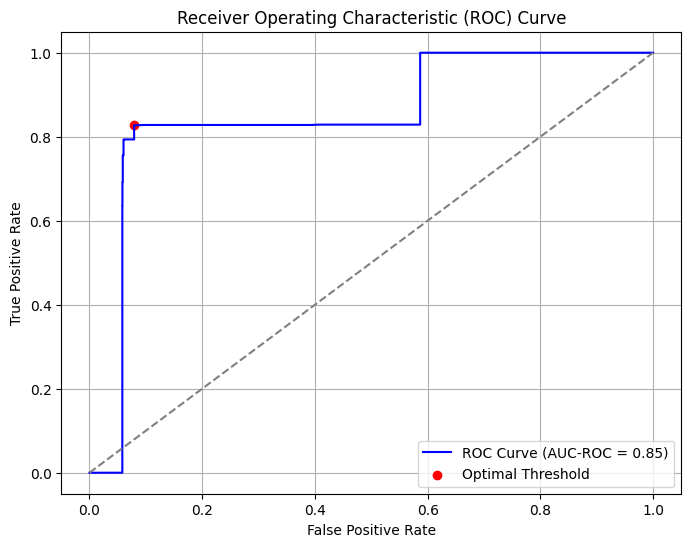

4147/4147 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
AUC-PR: 0.12951417017147276
Best Threshold (Precision-Recall): 0.07087863278741686


C:\Users\fraia\AppData\Local\Temp\ipykernel_21980\3924243696.py:8: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


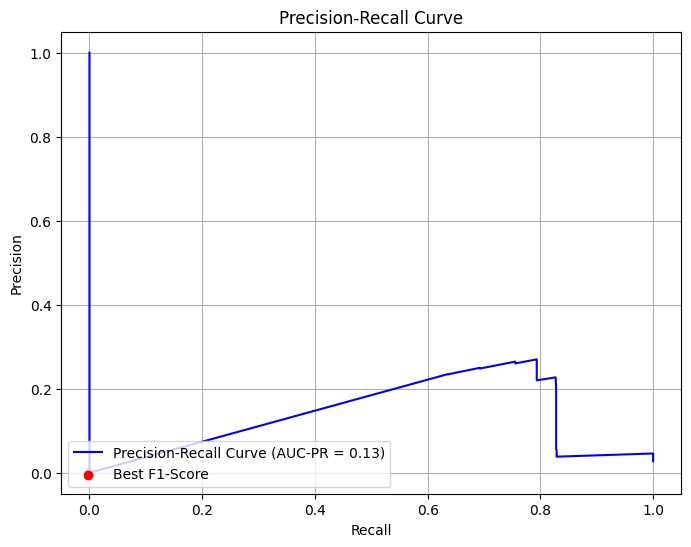

4147/4147 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


In [8]:
threshold_roc=curva_roc(y_test,loss)
predicted_labels_roc = detect_anomaly(X_test, autoencoder, threshold_roc)

threshold_pr = curva_precision_recall(y_test, loss)
predicted_labels_pr = detect_anomaly(X_test, autoencoder, threshold_pr)

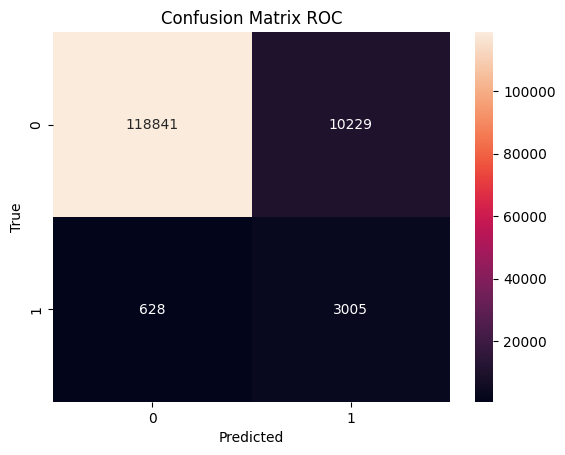

              precision    recall  f1-score   support

       False       0.99      0.92      0.96    129070
        True       0.23      0.83      0.36      3633

    accuracy                           0.92    132703
   macro avg       0.61      0.87      0.66    132703
weighted avg       0.97      0.92      0.94    132703


Accuracy con roc: 0.9181857230055085


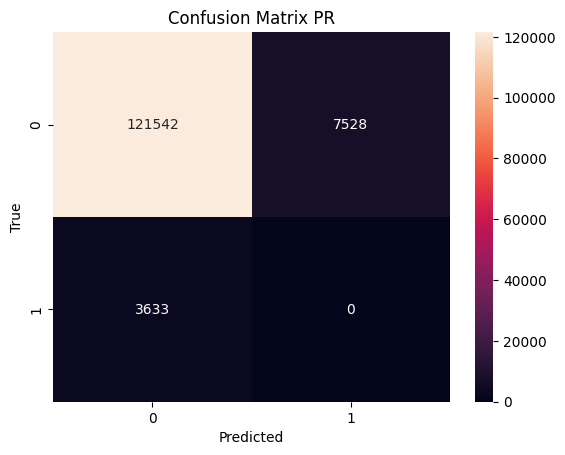

              precision    recall  f1-score   support

       False       0.97      0.94      0.96    129070
        True       0.00      0.00      0.00      3633

    accuracy                           0.92    132703
   macro avg       0.49      0.47      0.48    132703
weighted avg       0.94      0.92      0.93    132703


Accuracy con pr: 0.9158948931071641


In [9]:
# Conversione delle etichette test in un array booleano dove True indica un'anomalia
real_labels = y_test.to_numpy().astype(bool).flatten()

cm = confusion_matrix(real_labels, predicted_labels_roc)
sns.heatmap(cm, annot=True, fmt="d")    
plt.title("Confusion Matrix ROC")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(real_labels, predicted_labels_roc))
print("\nAccuracy con roc:", accuracy_score(real_labels, predicted_labels_roc))

cm = confusion_matrix(real_labels, predicted_labels_pr)
sns.heatmap(cm, annot=True, fmt="d")    
plt.title("Confusion Matrix PR")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(real_labels, predicted_labels_pr))
print("\nAccuracy con pr:", accuracy_score(real_labels, predicted_labels_pr))

4147/4147 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step


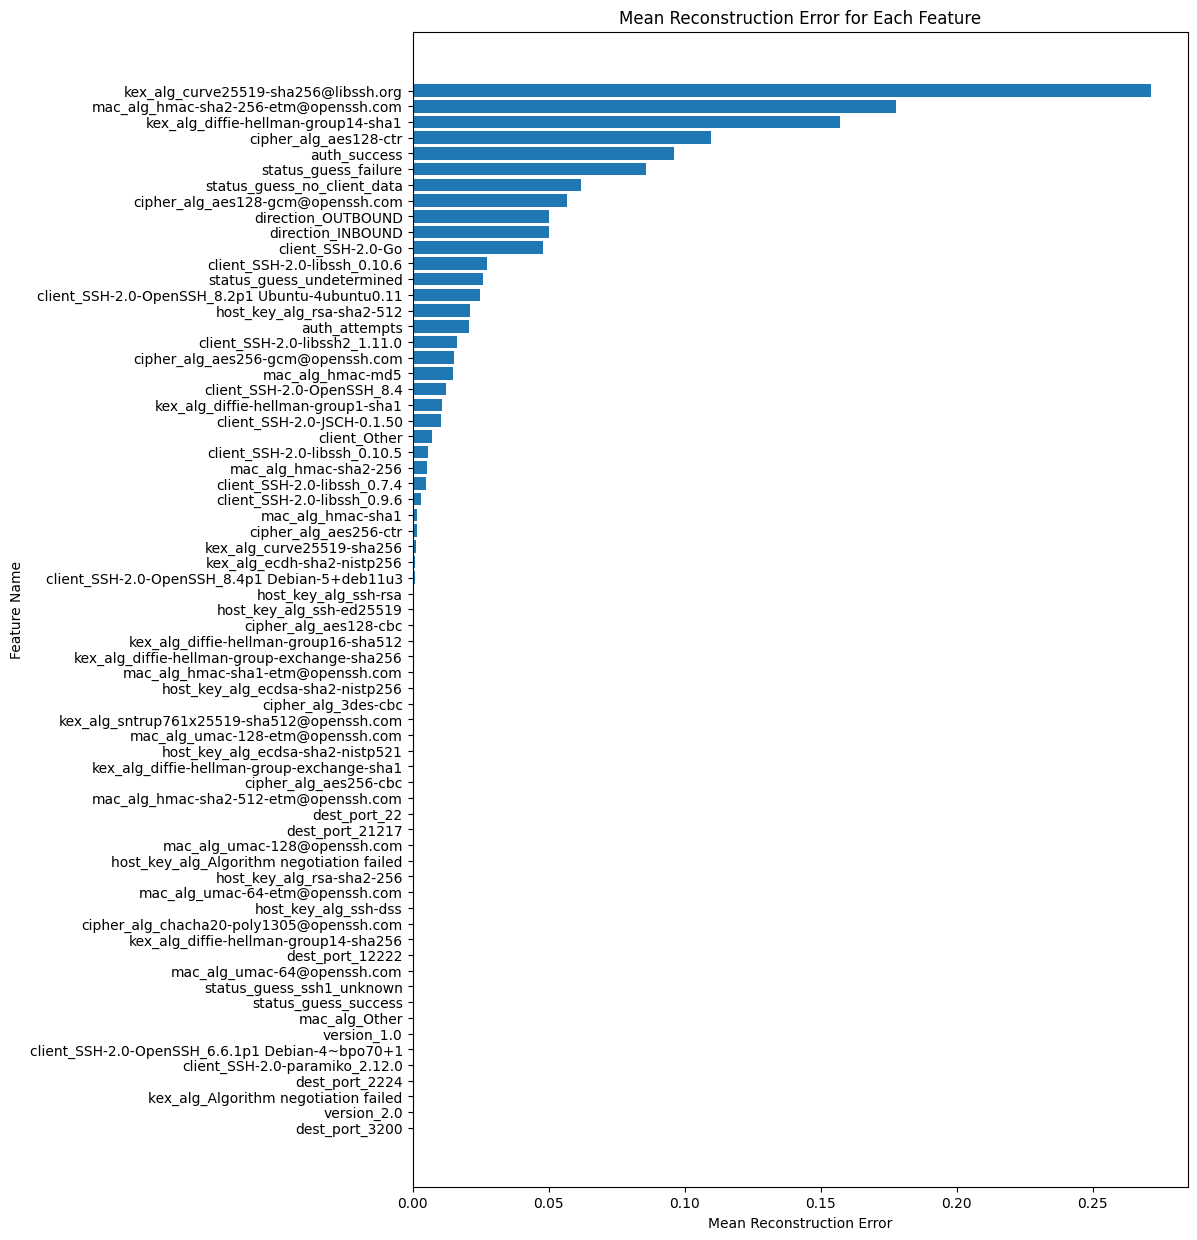

Features ordinate per errore di ricostruzione (dalla più influente):
Feature 'kex_alg_curve25519-sha256@libssh.org': Mean reconstruction error = 0.27121476928277966
Feature 'mac_alg_hmac-sha2-256-etm@openssh.com': Mean reconstruction error = 0.17782314762691193
Feature 'kex_alg_diffie-hellman-group14-sha1': Mean reconstruction error = 0.15689815485314068
Feature 'cipher_alg_aes128-ctr': Mean reconstruction error = 0.10950410011994346
Feature 'auth_success': Mean reconstruction error = 0.09622972019701906
Feature 'status_guess_failure': Mean reconstruction error = 0.08581427485632766
Feature 'status_guess_no_client_data': Mean reconstruction error = 0.0619328942021994
Feature 'cipher_alg_aes128-gcm@openssh.com': Mean reconstruction error = 0.056728425458699355
Feature 'direction_OUTBOUND': Mean reconstruction error = 0.05022016676674951
Feature 'direction_INBOUND': Mean reconstruction error = 0.050090914354238854
Feature 'client_SSH-2.0-Go': Mean reconstruction error = 0.048072865898583

In [10]:
#FEATURES
reconstructions = autoencoder.predict(X_test)

feature_names = X_test.columns

reconstruction_errors = np.abs(reconstructions - X_test) # Calcola l'errore di ricostruzione per ciascuna feature

mean_feature_error = np.mean(reconstruction_errors, axis=0) # Media dell'errore di ricostruzione su tutti i record per ciascuna feature

feature_error_dict = dict(zip(feature_names, mean_feature_error))

sorted_feature_error = sorted(feature_error_dict.items(), key=lambda x: x[1], reverse=True) # Ordina le feature in base all'errore medio di ricostruzione

plt.figure(figsize=(10, 15))
plt.barh([x[0] for x in sorted_feature_error], [x[1] for x in sorted_feature_error])
plt.gca().invert_yaxis() 
plt.xlabel('Mean Reconstruction Error')
plt.ylabel('Feature Name')
plt.title('Mean Reconstruction Error for Each Feature')
plt.show()

print("Features ordinate per errore di ricostruzione (dalla più influente):")
for feature, error in sorted_feature_error:
    print(f"Feature '{feature}': Mean reconstruction error = {error}")

In [148]:
false_negatives = X_test[(real_labels == True) & (predicted_labels_roc == False)]

dict_false_negatives = {}  
for col in X_test.columns:
    dict_false_negatives[col] = len(false_negatives[false_negatives[col] == 1])

sorted_dict_false_negatives = sorted(dict_false_negatives.items(), key=lambda x: x[1], reverse=True)

for feature, count in sorted_dict_false_negatives:
    print(f"Numero di falsi negativi con '{feature}' uguale a 1: {count}")


Numero di falsi negativi con 'dest_port_22' uguale a 1: 628
Numero di falsi negativi con 'direction_INBOUND' uguale a 1: 628
Numero di falsi negativi con 'kex_alg_curve25519-sha256' uguale a 1: 628
Numero di falsi negativi con 'mac_alg_hmac-sha2-256-etm@openssh.com' uguale a 1: 628
Numero di falsi negativi con 'version_2.0' uguale a 1: 628
Numero di falsi negativi con 'status_guess_undetermined' uguale a 1: 625
Numero di falsi negativi con 'cipher_alg_chacha20-poly1305@openssh.com' uguale a 1: 622
Numero di falsi negativi con 'client_SSH-2.0-libssh_0.10.6' uguale a 1: 622
Numero di falsi negativi con 'host_key_alg_ssh-ed25519' uguale a 1: 622
Numero di falsi negativi con 'cipher_alg_aes128-ctr' uguale a 1: 6
Numero di falsi negativi con 'client_SSH-2.0-Go' uguale a 1: 6
Numero di falsi negativi con 'host_key_alg_ecdsa-sha2-nistp256' uguale a 1: 6
Numero di falsi negativi con 'status_guess_no_client_data' uguale a 1: 3
Numero di falsi negativi con 'auth_attempts' uguale a 1: 0
Numero di

In [149]:
dict_real_positives = {}  
for col in X_test.columns:
    dict_real_positives[col] = len((X_test[(X_test[col] == 1) & (real_labels == True)]) )

sorted_dict_real_positives = sorted(dict_real_positives.items(), key=lambda x: x[1], reverse=True)

for feature, count in sorted_dict_real_positives:
    print(f"Numero di veri positivi con '{feature}' uguale a 1: {count}")

Numero di veri positivi con 'dest_port_22' uguale a 1: 3633
Numero di veri positivi con 'direction_INBOUND' uguale a 1: 3633
Numero di veri positivi con 'kex_alg_curve25519-sha256' uguale a 1: 3633
Numero di veri positivi con 'mac_alg_hmac-sha2-256-etm@openssh.com' uguale a 1: 3633
Numero di veri positivi con 'version_2.0' uguale a 1: 3633
Numero di veri positivi con 'client_SSH-2.0-libssh_0.10.6' uguale a 1: 3627
Numero di veri positivi con 'cipher_alg_chacha20-poly1305@openssh.com' uguale a 1: 3388
Numero di veri positivi con 'host_key_alg_ssh-ed25519' uguale a 1: 3388
Numero di veri positivi con 'status_guess_failure' uguale a 1: 2766
Numero di veri positivi con 'status_guess_undetermined' uguale a 1: 742
Numero di veri positivi con 'cipher_alg_aes128-ctr' uguale a 1: 245
Numero di veri positivi con 'host_key_alg_ecdsa-sha2-nistp256' uguale a 1: 245
Numero di veri positivi con 'status_guess_no_client_data' uguale a 1: 125
Numero di veri positivi con 'client_SSH-2.0-Go' uguale a 1: 6

In [150]:
false_positives = X_test[(real_labels == False) & (predicted_labels_roc == True)]

dict_false_positives = {}  
for col in X_test.columns:
    dict_false_positives[col] = len(false_positives[(false_positives[col] == 1)])

sorted_dict_false_positives = sorted(dict_false_positives.items(), key=lambda x: x[1], reverse=True)

for feature, count in sorted_dict_false_positives:
    print(f"Numero di falsi positivi con '{feature}' uguale a 1: {count}")

Numero di falsi positivi con 'version_2.0' uguale a 1: 10229
Numero di falsi positivi con 'dest_port_22' uguale a 1: 10222
Numero di falsi positivi con 'host_key_alg_ecdsa-sha2-nistp256' uguale a 1: 10040
Numero di falsi positivi con 'kex_alg_curve25519-sha256' uguale a 1: 10018
Numero di falsi positivi con 'cipher_alg_aes128-ctr' uguale a 1: 9963
Numero di falsi positivi con 'mac_alg_hmac-sha2-256-etm@openssh.com' uguale a 1: 9917
Numero di falsi positivi con 'status_guess_no_client_data' uguale a 1: 7341
Numero di falsi positivi con 'direction_OUTBOUND' uguale a 1: 6676
Numero di falsi positivi con 'client_SSH-2.0-Go' uguale a 1: 6595
Numero di falsi positivi con 'direction_INBOUND' uguale a 1: 3553
Numero di falsi positivi con 'status_guess_undetermined' uguale a 1: 2726
Numero di falsi positivi con 'client_SSH-2.0-OpenSSH_8.4' uguale a 1: 2131
Numero di falsi positivi con 'client_SSH-2.0-libssh_0.7.4' uguale a 1: 664
Numero di falsi positivi con 'client_Other' uguale a 1: 310
Numer

In [151]:
dict_test = {}  
for col in X_test.columns:
    dict_test[col] = len((X_test[(X_test[col] == 1) ]) )

sorted_dict_test = sorted(dict_test.items(), key=lambda x: x[1], reverse=True)

for feature, count in sorted_dict_test:
    print(f"Numero di record con '{feature}' uguale a 1: {count}")

Numero di record con 'version_2.0' uguale a 1: 132703
Numero di record con 'dest_port_22' uguale a 1: 132696
Numero di record con 'direction_INBOUND' uguale a 1: 125908
Numero di record con 'host_key_alg_ecdsa-sha2-nistp256' uguale a 1: 77295
Numero di record con 'mac_alg_hmac-sha2-256-etm@openssh.com' uguale a 1: 75201
Numero di record con 'kex_alg_curve25519-sha256' uguale a 1: 65447
Numero di record con 'client_SSH-2.0-Go' uguale a 1: 60159
Numero di record con 'cipher_alg_aes128-ctr' uguale a 1: 53979
Numero di record con 'status_guess_undetermined' uguale a 1: 52202
Numero di record con 'status_guess_failure' uguale a 1: 47765
Numero di record con 'kex_alg_curve25519-sha256@libssh.org' uguale a 1: 35991
Numero di record con 'mac_alg_hmac-sha2-256' uguale a 1: 28602
Numero di record con 'cipher_alg_chacha20-poly1305@openssh.com' uguale a 1: 28147
Numero di record con 'host_key_alg_ssh-rsa' uguale a 1: 28121
Numero di record con 'mac_alg_umac-64-etm@openssh.com' uguale a 1: 24721
Nu

In [152]:
dict_train = {}  
for col in X_train.columns:
    dict_train[col] = len((X_train[(X_train[col] == 1) ]) )

sorted_dict_train = sorted(dict_train.items(), key=lambda x: x[1], reverse=True)

for feature, count in sorted_dict_train:
    print(f"Numero di record con '{feature}' uguale a 1: {count}")

Numero di record con 'dest_port_22' uguale a 1: 433892
Numero di record con 'version_2.0' uguale a 1: 433886
Numero di record con 'direction_INBOUND' uguale a 1: 410191
Numero di record con 'host_key_alg_ecdsa-sha2-nistp256' uguale a 1: 283818
Numero di record con 'kex_alg_curve25519-sha256' uguale a 1: 265283
Numero di record con 'status_guess_undetermined' uguale a 1: 234229
Numero di record con 'mac_alg_hmac-sha2-256' uguale a 1: 196820
Numero di record con 'cipher_alg_aes256-ctr' uguale a 1: 176032
Numero di record con 'client_SSH-2.0-libssh_0.7.4' uguale a 1: 136775
Numero di record con 'mac_alg_hmac-sha2-256-etm@openssh.com' uguale a 1: 124346
Numero di record con 'kex_alg_ecdh-sha2-nistp256' uguale a 1: 109542
Numero di record con 'cipher_alg_chacha20-poly1305@openssh.com' uguale a 1: 96835
Numero di record con 'mac_alg_umac-64-etm@openssh.com' uguale a 1: 96666
Numero di record con 'client_SSH-2.0-OpenSSH_8.4' uguale a 1: 95277
Numero di record con 'auth_success' uguale a 1: 89